In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process import *


from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Does the MI estimator correctly estimate MI for samples from a stationary process with known MI

stick to additive Gaussian noise, H(Y) can be computed analytically. The covariance matrix for p(y) is just the one for p(x) with sigma**2 * I added to it

In [2]:
# Compute a "true" reference covariance matrix
num_images = 5000
num_patches = 15000
edge_crop = 32
# patch_size = 50
patch_size = 15
channel = 'LED119'
eigenvalue_floor = 1e-3


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor)
cov_mat_stationary = estimate_stationary_cov_mat(patches, eigenvalue_floor=eigenvalue_floor)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=eigenvalue_floor)
cov_mat_stationary_optimized = estimate_stationary_cov_mat(patches, eigenvalue_floor=eigenvalue_floor, optimize=True, verbose=True)


/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -31.70713134616631
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'


Initial loss:  4324.170010772605
\Optimized loss:  4.23059692429837166813384641615


#### Verify that you can estimate a Covariance mat and its analytic entropy from samples of it

100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Text(0.5, 1.0, 'Entropy error\nper pixel')

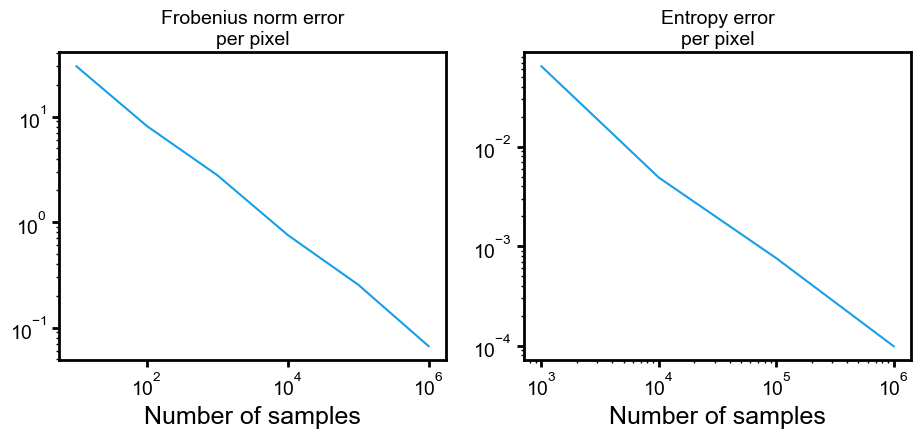

In [3]:
# now sample from the covariance matrix, estimate a new covart
seed = 0
num_samples_list = np.logspace(1, 6, 6, dtype=int)

mat_to_estimate = cov_mat
# mat_to_estimate = cov_mat_stationary_pd

true_entropy = analytic_multivariate_gaussian_entropy(mat_to_estimate) 

fro_norm_errors = []
entropy_errors = []
for num_samples in tqdm(num_samples_list):
    samples = jax.random.multivariate_normal(jax.random.PRNGKey(seed), np.zeros(mat_to_estimate.shape[0]), mat_to_estimate, shape=(num_samples,))
    cov_mat_estimate = estimate_cov_mat(samples)
    # compute Frobenius norm of difference between cov_mat_estimate and cov_mat
    error = np.linalg.norm(cov_mat_estimate - mat_to_estimate, ord='fro') / mat_to_estimate.size
    fro_norm_errors.append(error)
    estimated_entropy = analytic_multivariate_gaussian_entropy(cov_mat_estimate) 
    entropy_error = np.abs(estimated_entropy - true_entropy)
    entropy_errors.append(entropy_error)

    
# plot errors
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].loglog(num_samples_list, fro_norm_errors)
ax[0].set_xlabel('Number of samples')
ax[0].set_title('Frobenius norm error\nper pixel')

ax[1].loglog(num_samples_list, entropy_errors)
ax[1].set_xlabel('Number of samples')
ax[1].set_title('Entropy error\nper pixel')


### Now verify that mutual information estimates converge to the true value with increasing number of samples

In [4]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it

num_images = 10000
num_patches = 50000
edge_crop = 24

patch_size = 12

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_cov_mat(patches)
true_cov_mat_px = estimate_stationary_cov_mat(patches, optimize=True)
true_mean_px = np.mean(images)


In [5]:
samples = generate_stationary_gaussian_process_samples(mean_vec=np.ones(true_cov_mat_px.shape[0]) * true_mean_px,
                cov_mat=true_cov_mat_px, sample_size=patch_size, num_samples=num_patches, ensure_nonnegative=True)

### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [6]:

num_samples_to_use = np.array([4, 20, 100, 500, 2500, 5000, 10000, 20000])
num_bootstrap_samples = 10

# num_samples_to_use = np.array([4, 20, 2500])
# num_bootstrap_samples = 10

gaussian_sigma = 50
confidence_interval = 90

h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)

# plot several samples and their corresponding noisy samples
# num_to_show = 8
# fig, ax = plt.subplots(2, num_to_show, figsize=(num_to_show * 2, 4))
# for i in range(num_to_show):
#     ax[0, i].imshow(samples[i].reshape(patch_size, patch_size), cmap='inferno')
#     ax[1, i].imshow(noisy_samples[i].reshape(patch_size, patch_size), cmap='inferno')
#     ax[0, i].set_title('Noiseless')
#     ax[1, i].set_title('Noisy')
#     ax[0,i].axis('off')
#     ax[1,i].axis('off')


h_x_estimates_mean = []
h_x_estimates_conf_int = []
h_x_estimates_optimized_mean = []
h_x_estimates_optimized_conf_int = []

h_y_estimates_mean = []
h_y_estimates_conf_int = []
h_y_estimates_optimized_mean = []
h_y_estimates_optimized_conf_int = []

stationary_h_x_estimates_mean = []
stationary_h_x_estimates_conf_int = []
stationary_h_x_estimates_optimized_mean = []
stationary_h_x_estimates_optimized_conf_int = []

stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_h_y_estimates_optimized_mean = []
stationary_h_y_estimates_optimized_conf_int = []

h_y_given_x_estimates_mean = []
h_y_given_x_estimates_conf_int = []

stationary_mi_estimates_mean = []
stationary_mi_estimates_conf_int = []
stationary_mi_estimates_optimized_mean = []
stationary_mi_estimates_optimized_conf_int = []

ev_floor = 1e2
for num_to_use in tqdm(num_samples_to_use):
    # estiamte noisy and noiseless entropies using stationary and non-stationary estimators
    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                  lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval )                  
    h_x_estimates_mean.append(mean)
    h_x_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval )
    h_x_estimates_optimized_mean.append(mean)
    h_x_estimates_optimized_conf_int.append(conf_int)


    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval )
    stationary_h_x_estimates_mean.append(mean)
    stationary_h_x_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval )
    stationary_h_x_estimates_optimized_mean.append(mean)
    stationary_h_x_estimates_optimized_conf_int.append(conf_int)
                                   

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval )
    h_y_estimates_mean.append(mean)
    h_y_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval )
    h_y_estimates_optimized_mean.append(mean)
    h_y_estimates_optimized_conf_int.append(conf_int)


    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval)
    stationary_h_y_estimates_mean.append(mean)
    stationary_h_y_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval )
    stationary_h_y_estimates_optimized_mean.append(mean)
    stationary_h_y_estimates_optimized_conf_int.append(conf_int)


    # estimate conditional entropy
    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: estimate_conditional_entropy(data), confidence_interval=confidence_interval )
    h_y_given_x_estimates_mean.append(mean)
    h_y_given_x_estimates_conf_int.append(conf_int)

    # estimate MI using stationary estimator
    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]}, 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, ) )
    stationary_mi_estimates_mean.append(mean)
    stationary_mi_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]}, 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, use_iterative_optimization=True) )
    stationary_mi_estimates_optimized_mean.append(mean)
    stationary_mi_estimates_optimized_conf_int.append(conf_int)


h_x_estimates_conf_int = np.array(h_x_estimates_conf_int)
h_x_estimates_mean = np.array(h_x_estimates_mean)
h_x_estimates_optimized_mean = np.array(h_x_estimates_optimized_mean)
h_x_estimates_optimized_conf_int = np.array(h_x_estimates_optimized_conf_int)

h_y_estimates_conf_int = np.array(h_y_estimates_conf_int)
h_y_estimates_mean = np.array(h_y_estimates_mean)
h_y_estimates_optimized_mean = np.array(h_y_estimates_optimized_mean)
h_y_estimates_optimized_conf_int = np.array(h_y_estimates_optimized_conf_int)

stationary_h_x_estimates_conf_int = np.array(stationary_h_x_estimates_conf_int)
stationary_h_x_estimates_mean = np.array(stationary_h_x_estimates_mean)
stationary_h_x_estimates_optimized_conf_int = np.array(stationary_h_x_estimates_optimized_conf_int)
stationary_h_x_estimates_optimized_mean = np.array(stationary_h_x_estimates_optimized_mean)

stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_h_y_estimates_optimized_conf_int = np.array(stationary_h_y_estimates_optimized_conf_int)
stationary_h_y_estimates_optimized_mean = np.array(stationary_h_y_estimates_optimized_mean)

h_y_given_x_estimates_conf_int = np.array(h_y_given_x_estimates_conf_int)
h_y_given_x_estimates_mean = np.array(h_y_given_x_estimates_mean)

stationary_mi_estimates_conf_int = np.array(stationary_mi_estimates_conf_int)
stationary_mi_estimates_mean = np.array(stationary_mi_estimates_mean)
stationary_mi_estimates_optimized_conf_int = np.array(stationary_mi_estimates_optimized_conf_int)
stationary_mi_estimates_optimized_mean = np.array(stationary_mi_estimates_optimized_mean)

  0%|          | 0/8 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -31157.28347845393
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'
/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -35435.41335065698
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'
/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:43: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -19766.362151035937
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using po

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_24767/2303106408.py", line 80, in <module>
    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
  File "/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py", line 201, in run_bootstrap
    results.append(estimation_fn(data_sample))
  File "/tmp/ipykernel_24767/2303106408.py", line 81, in <lambda>
    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval )
  File "/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py", line 99, in gaussian_entropy_estimate
    mean_vec, cov_mat = estimate_stationary_cov_mat(X, eigenvalue_floor=eig

In [9]:
    
# plot estimates vs true value
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].fill_between(num_samples_to_use, h_x_estimates_conf_int[:,0], h_x_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax[0].semilogx(num_samples_to_use, h_x_estimates_mean, label='Estimated')
ax[0].fill_between(num_samples_to_use, h_x_estimates_optimized_conf_int[:,0], h_x_estimates_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax[0].semilogx(num_samples_to_use, h_x_estimates_optimized_mean, label='Estimated (optimized)')
ax[0].axhline(h_x_analytic, color='k', linestyle='--', label='True')
ax[0].set(xlabel='Number of samples', title='nonstationary h(x) estimate\nper pixel', ylabel='Differential entropy per pixel')
clear_spines(ax[0])
ax[0].legend()

ax[1].fill_between(num_samples_to_use, stationary_h_x_estimates_conf_int[:,0], stationary_h_x_estimates_conf_int[:,1], alpha=0.5)
ax[1].semilogx(num_samples_to_use, stationary_h_x_estimates_mean)
ax[1].fill_between(num_samples_to_use, stationary_h_x_estimates_optimized_conf_int[:,0], stationary_h_x_estimates_optimized_conf_int[:,1], alpha=0.5)
ax[1].semilogx(num_samples_to_use, stationary_h_x_estimates_optimized_mean)
ax[1].axhline(h_x_analytic, color='k', linestyle='--')
ax[1].set(xlabel='Number of samples', title='stationary h(x) estimate\nper pixel')
clear_spines(ax[1])


fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].fill_between(num_samples_to_use, h_y_estimates_conf_int[:,0], h_y_estimates_conf_int[:,1], alpha=0.5)
ax[0].semilogx(num_samples_to_use, h_y_estimates_mean)
ax[0].fill_between(num_samples_to_use, h_y_estimates_optimized_conf_int[:,0], h_y_estimates_optimized_conf_int[:,1], alpha=0.5)
ax[0].semilogx(num_samples_to_use, h_y_estimates_optimized_mean)
ax[0].axhline(h_y_analytic, color='k', linestyle='--')
ax[0].set(xlabel='Number of samples', title='nonstationary h(y) estimate\nper pixel')
clear_spines(ax[0])

ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.5)
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_mean)
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.5)
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean)
ax[1].axhline(h_y_analytic, color='k', linestyle='--')
ax[1].set(xlabel='Number of samples', title='stationary h(y) estimate\nper pixel')
clear_spines(ax[1])

# conditional entropy
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, h_y_given_x_estimates_conf_int[:,0], h_y_given_x_estimates_conf_int[:,1], alpha=0.5)
ax.semilogx(num_samples_to_use, h_y_given_x_estimates_mean)
ax.set(xlabel='Number of samples', title='h(y|x) estimate\nper pixel')
clear_spines(ax)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, stationary_mi_estimates_conf_int[:,0], 
                stationary_mi_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.fill_between(num_samples_to_use, stationary_mi_estimates_optimized_conf_int[:,0], 
                stationary_mi_estimates_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_mean, label='Estimated')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_optimized_mean, label='Estimated (optimized)')
ax.axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')


ax.set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax)
ax.legend()


[autoreload of jax._src.lib failed: Traceback (most recent call last):
  File "/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 73, in <module>
    version_str = jaxlib.version.__version__
AttributeError: module 'jaxl

: 

### Make sure the cov mats look like what you expect

In [8]:
_, cov_mat_full, _ = gaussian_entropy_estimate(noisy_samples, stationary=False, eigenvalue_floor=ev_floor, return_cov_mat_and_mean=True)
_, cov_mat_stationary, _ = gaussian_entropy_estimate(noisy_samples, stationary=True, eigenvalue_floor=ev_floor, return_cov_mat_and_mean=True)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1)

# imshow cov_mat_full
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(true_cov_mat_px, cmap='inferno')
ax[0].set_title('True covariance matrix')
ax[1].imshow(cov_mat_full, cmap='inferno')
ax[1].set_title('Estimated full covariance matrix')
ax[2].imshow(cov_mat_stationary, cmap='inferno')
ax[2].set_title('Estimated stationary covariance matrix')
ax[3].imshow(cov_mat_stationary_pd, cmap='inferno')
ax[3].set_title('Estimated stationary + PD covariance matrix')

TypeError: append(): incompatible function arguments. The following argument types are supported:
    1. (self: jaxlib.mlir._mlir_libs._mlir.ir.BlockList, *args) -> jaxlib.mlir._mlir_libs._mlir.ir.Block

Invoked with: <jaxlib.mlir._mlir_libs._mlir.ir.BlockList object at 0x7fa194a0f470>, Type(tensor<50000x144xf64>); kwargs: arg_locs=None

# Same MI consistency plot, but with samples from data distrbution instead of GP
Cant show it converging to true value, but can show that it converges to a (probably biased) estimate

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [08:56<00:00, 67.10s/it]


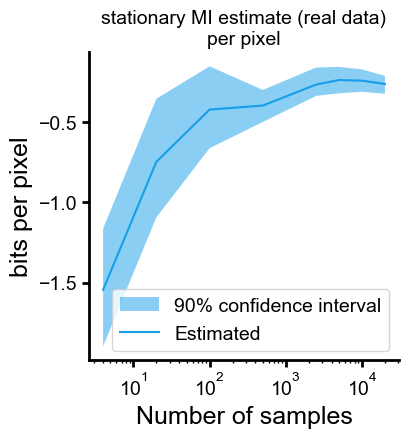

In [ ]:
stationary_mi_estimates_mean = []
stationary_mi_estimates_conf_int = []
stationary_mi_estimates_optimized_mean = []
stationary_mi_estimates_optimized_conf_int = []
for num_to_use in tqdm(num_samples_to_use):
    # estimate MI using stationary estimator
    mean, conf_int = run_bootstrap(patches[:num_to_use], 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images: estimate_mutual_information(noisy_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor ) )
    stationary_mi_estimates_mean.append(mean)
    stationary_mi_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(patches[:num_to_use],
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images: estimate_mutual_information(noisy_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor, use_iterative_optimization=True) )
    stationary_mi_estimates_optimized_mean.append(mean)
    stationary_mi_estimates_optimized_conf_int.append(conf_int)

stationary_mi_estimates_conf_int = np.array(stationary_mi_estimates_conf_int)
stationary_mi_estimates_mean = np.array(stationary_mi_estimates_mean)
stationary_mi_estimates_optimized_conf_int = np.array(stationary_mi_estimates_optimized_conf_int)
stationary_mi_estimates_optimized_mean = np.array(stationary_mi_estimates_optimized_mean)


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, stationary_mi_estimates_conf_int[:,0], stationary_mi_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_mean, label='Estimated')
ax.fill_between(num_samples_to_use, stationary_mi_estimates_optimized_conf_int[:,0], stationary_mi_estimates_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_optimized_mean, label='Estimated (optimized)')


ax.set(xlabel='Number of samples', title='stationary MI estimate (real data)\nper pixel', ylabel='bits per pixel')
clear_spines(ax)
ax.legend()


## Estimating H(Y | X)

### Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

#### Load images

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [10:26<00:00, 208.69s/it]


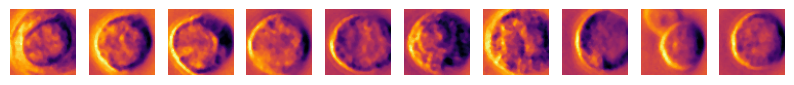

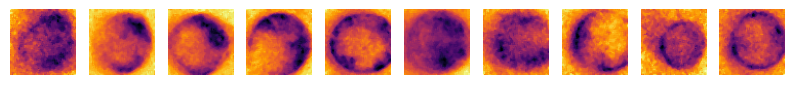

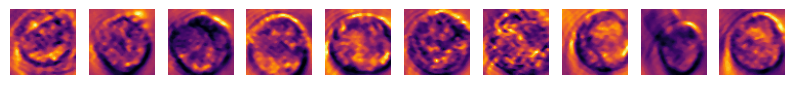

In [ ]:
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

images = {}
clean_patches_by_channel = {}
for channel in tqdm(channels):
    # load "clean" median filtered images
    images[channel] = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=32, median_filter=True)        
    clean_patches_by_channel[channel] = extract_patches(images[channel], patch_size, num_patches=num_patches)

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

#### Compare conditional entropy of noisy to clean

In [ ]:
mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}
photons_per_pixel_list = [5, 10, 20, 40, 80, 160, 320]
num_bootstraps = 10
patch_size = 15
num_patches = 10000
confidence_interval = 90

results = {}
for channel in channels:
    results[channel] = []
    for photons_per_pixel in tqdm(photons_per_pixel_list):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_patches = clean_patches_by_channel[channel] * rescale_fractions[channel]
        noisy_patches = add_noise(clean_patches, ensure_positive=True)

        noisy_conditional_mean, noisy_conditional_interval = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                             lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
        clean_conditional_mean, clean_conditional_interval = run_bootstrap({'clean_images': clean_patches, 'noisy_images': noisy_patches},
                                                                            num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                                lambda noisy_images, clean_images: estimate_mutual_information(noisy_images=noisy_images, clean_images=clean_images, verbose=False))
        results[channel].append((noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval))
        

  0%|          | 0/5 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:233: UserWarning: Mean pixel value is 19.83. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:233: UserWarning: Mean pixel value is 19.82. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:233: UserWarning: Mean pixel value is 19.84. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual i

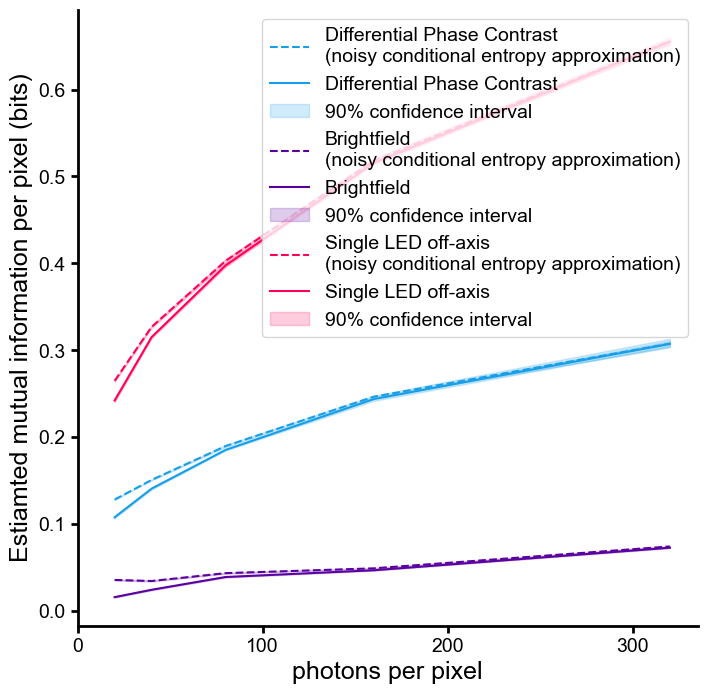

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    noisy_conditional_means = []
    noisy_conditional_intervals = []
    clean_conditional_means = []
    clean_conditional_intervals = []
    for noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval in channel_results:
        noisy_conditional_means.append(noisy_conditional_mean)
        noisy_conditional_intervals.append(noisy_conditional_interval)
        clean_conditional_means.append(clean_conditional_mean)
        clean_conditional_intervals.append(clean_conditional_interval)
    noisy_conditional_means = np.array(noisy_conditional_means)
    noisy_conditional_intervals = np.array(noisy_conditional_intervals)
    clean_conditional_means = np.array(clean_conditional_means)
    clean_conditional_intervals = np.array(clean_conditional_intervals)
    
    channel_name = get_display_channel_names(channel)
    ax.plot(photons_per_pixel_list, noisy_conditional_means, '--',label=channel_name + '\n(noisy conditional entropy approximation)', color=color)
    ax.fill_between(photons_per_pixel_list, noisy_conditional_intervals[:, 0], noisy_conditional_intervals[:, 1], alpha=0.2, 
                    color=color)
                    #   hatch='x',)
    ax.plot(photons_per_pixel_list, clean_conditional_means, '-', label=channel_name , color=color)
    ax.fill_between(photons_per_pixel_list, clean_conditional_intervals[:, 0], clean_conditional_intervals[:, 1], alpha=0.2, 
                    color=color, label=f'{confidence_interval}% confidence interval', )
                    # hatch='.')
    ax.set(xticks=[0, 100, 200, 300])

clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estiamted mutual information per pixel (bits)')
ax.legend()